# L&I API
## Pulling data on constructions from 2020 to present

#### L&I is used here as an abbreviation for the Department of Licenses and Inspections. The table we are pulling from in the L&I API is for Building and Zoning Permits. This dataset contains application information on all building and zoning permits petitioned in the city. It spans from 2007 to present-day and it was last updated 03/30/2023.

In [1]:
import carto
import requests
from sklearn.cluster import KMeans
import geopandas as gpd
import pandas as pd
import rtree

###### Pull permit requests from L&I's API
Collect data from 01/01/2020 to present for new construction and permits requested by contractors. New construction will not capture all types of construction that contribute to illegal dumping, but it will speak to the issue of developers cutting corners that community groups rally against. This is also why I chose to filter for permits requested by contractors.

In [15]:
#connect to LNI API

url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM permits
        WHERE permitissuedate >= '2020-01-01' AND typeofwork = 'NEW CONSTRUCTION' OR applicanttype = 'CONTRACTOR'
        '''

response = requests.get(url)

data = response.json()
data

{'rows': [{'cartodb_id': 1,
   'the_geom': '0101000020E610000025522E0FC0CB52C0B4893B6E5FF74340',
   'the_geom_webmercator': '0101000020110F000048639CF13DED5FC111088E2C56865241',
   'objectid': 15,
   'permitnumber': '1004127',
   'addressobjectid': '565450',
   'parcel_id_num': '357397',
   'permittype': 'PP_PLUMBNG',
   'permitdescription': 'PLUMBING PERMIT',
   'commercialorresidential': None,
   'typeofwork': 'EZPLUM',
   'approvedscopeofwork': 'REPLACE WATER DISTRIBUTION SERVICE AS PER PHILADELPHIA 2014 PLUMBING CODE',
   'permitissuedate': '2019-08-21T11:16:58Z',
   'status': 'COMPLETED',
   'applicanttype': 'CONTRACTOR',
   'contractorname': 'RELIABLE PLUMBING & DRAIN CLNG',
   'contractoraddress1': '2 RYERS AVENUE',
   'contractoraddress2': None,
   'contractorcity': 'CHELTENHAM',
   'contractorstate': 'PA',
   'contractorzip': '19012-    ',
   'mostrecentinsp': '2019-09-03T11:20:00Z',
   'opa_account_num': '364063400',
   'address': '2317 TASKER ST',
   'unit_type': None,
   'u

In [17]:
print(len(data['rows']))

398311


#### Convert data to dataframe

In [19]:
df = pd.DataFrame.from_dict(data['rows'])
df.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,...,unit_type,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid
0,1,0101000020E610000025522E0FC0CB52C0B4893B6E5FF7...,0101000020110F000048639CF13DED5FC111088E2C5686...,15,1004127,565450,357397,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,None,19145-1330,32,2,WILLIAMS THELMA,HANSEN,2.688116e+06,228761.877700,None
1,5,0101000020E6100000599EBB563ACE52C0AE9F2269A8F8...,0101000020110F0000F752D35473F15FC1E2017093C287...,19,100672,616321,168348,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,None,19143-4239,73,3,CHARLES COOPER ADA E,HANSEN,2.677159e+06,232104.570025,None
2,11,0101000020E610000050109F16C4CE52C06234C9757B06...,0101000020110F000078AD16505DF25FC1E3BC4F111697...,33,1010094,612738,253361,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,None,19128-3131,217,4,MANCINI JOSEPH C MANCINI BARBARA J,HANSEN,2.673681e+06,271364.897926,None
3,12,0101000020E6100000B200B1CD71C952C049762C538BF6...,0101000020110F0000653DBB5553E95FC1287349426B85...,34,1010099,304012,464491,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,None,19148-2023,27.02,1,DEL SIGNORE ANTHONY M DEL SIGNORE SARAH J,HANSEN,2.698285e+06,226700.547626,None
4,21,0101000020E6100000FA99C93E86C952C0BFD980CCAEF7...,0101000020110F000048F5AB0E76E95FC1E0D44515AE86...,1,100006,633726,285630,BP_MECH,MECHANICAL PERMIT,None,...,None,None,19147-4201,25,1,SALEM JONATHAN,HANSEN,2.697839e+06,229929.150161,None


In [21]:
df.columns

Index(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'objectid',
       'permitnumber', 'addressobjectid', 'parcel_id_num', 'permittype',
       'permitdescription', 'commercialorresidential', 'typeofwork',
       'approvedscopeofwork', 'permitissuedate', 'status', 'applicanttype',
       'contractorname', 'contractoraddress1', 'contractoraddress2',
       'contractorcity', 'contractorstate', 'contractorzip', 'mostrecentinsp',
       'opa_account_num', 'address', 'unit_type', 'unit_num', 'zip',
       'censustract', 'council_district', 'opa_owner', 'systemofrecord',
       'geocode_x', 'geocode_y', 'posse_jobid'],
      dtype='object')

#### Convert dataframe to geodataframe using the CRS in the metadata

In [30]:
gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['geocode_x'], df['geocode_y']),crs="ESRI:102729")
gdf.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,...,unit_num,zip,censustract,council_district,opa_owner,systemofrecord,geocode_x,geocode_y,posse_jobid,geometry
0,1,0101000020E610000025522E0FC0CB52C0B4893B6E5FF7...,0101000020110F000048639CF13DED5FC111088E2C5686...,15,1004127,565450,357397,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19145-1330,32,2,WILLIAMS THELMA,HANSEN,2.688116e+06,228761.877700,None,POINT (2688116.300 228761.878)
1,5,0101000020E6100000599EBB563ACE52C0AE9F2269A8F8...,0101000020110F0000F752D35473F15FC1E2017093C287...,19,100672,616321,168348,PP_PLUMBNG,PLUMBING PERMIT,None,...,None,19143-4239,73,3,CHARLES COOPER ADA E,HANSEN,2.677159e+06,232104.570025,None,POINT (2677159.444 232104.570)
2,11,0101000020E610000050109F16C4CE52C06234C9757B06...,0101000020110F000078AD16505DF25FC1E3BC4F111697...,33,1010094,612738,253361,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,19128-3131,217,4,MANCINI JOSEPH C MANCINI BARBARA J,HANSEN,2.673681e+06,271364.897926,None,POINT (2673680.734 271364.898)
3,12,0101000020E6100000B200B1CD71C952C049762C538BF6...,0101000020110F0000653DBB5553E95FC1287349426B85...,34,1010099,304012,464491,EP_ELECTRL,ELECTRICAL PERMIT,None,...,None,19148-2023,27.02,1,DEL SIGNORE ANTHONY M DEL SIGNORE SARAH J,HANSEN,2.698285e+06,226700.547626,None,POINT (2698284.621 226700.548)
4,21,0101000020E6100000FA99C93E86C952C0BFD980CCAEF7...,0101000020110F000048F5AB0E76E95FC1E0D44515AE86...,1,100006,633726,285630,BP_MECH,MECHANICAL PERMIT,None,...,None,19147-4201,25,1,SALEM JONATHAN,HANSEN,2.697839e+06,229929.150161,None,POINT (2697839.417 229929.150)


###### Change the CRS of the L&I point data to match the CRS of the census tracts

In [31]:
#change crs
gdf.to_crs('EPSG:2272')
gdf.crs

<Projected CRS: ESRI:102729>
Name: NAD_1983_StatePlane_Pennsylvania_South_FIPS_3702_Feet
Axis Info [cartesian]:
- E[east]: Easting (US survey foot)
- N[north]: Northing (US survey foot)
Area of Use:
- name: USA - Pennsylvania - SPCS - S
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: NAD_1983_StatePlane_Pennsylvania_South_FIPS_3702_Feet
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot: >

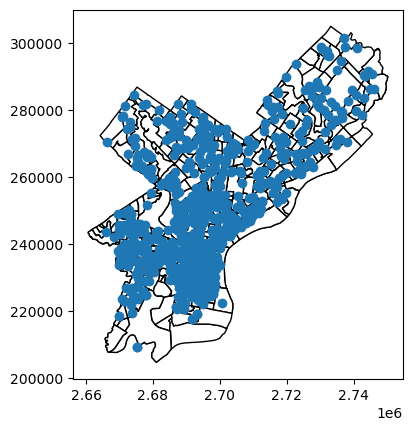

In [35]:
#add tracts to check CRS
tracts = gpd.read_file("output/tracts.gpkg")
ax = tracts.plot(color='white', edgecolor='black')
gdf.head(1000).plot(ax=ax)

#### Aggregate the L&I data to the census tract level
Perform a spatial join. This determines which polygon a L&I point falls within and joins the appropriate tract data to each L&I point.

In [36]:
#aggregate points
agg = gpd.sjoin(gdf, tracts, how="inner", op='within')
agg.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,permitnumber,addressobjectid,parcel_id_num,permittype,permitdescription,commercialorresidential,...,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,count,status_right
0,1,0101000020E610000025522E0FC0CB52C0B4893B6E5FF7...,0101000020110F000048639CF13DED5FC111088E2C5686...,15,1004127,565450,357397,PP_PLUMBNG,PLUMBING PERMIT,None,...,32,Census Tract 32,G5020,S,491790,0,+39.9333011,-075.1854187,1484,1477
13,44,0101000020E61000001B23DC95D3CB52C0FCA0D9191FF7...,0101000020110F0000D5C05E1C5FED5FC13D7898EC0E86...,35,1010180,483601,492847,BP_ALTER,ALTERATION PERMIT,None,...,32,Census Tract 32,G5020,S,491790,0,+39.9333011,-075.1854187,1484,1477
177,324,0101000020E610000037D366AAABCB52C01F7C88BA5FF7...,0101000020110F00003A88974D1BED5FC1238910815686...,310,168345,104756,495468,EP_ELECTRL,ELECTRICAL PERMIT,None,...,32,Census Tract 32,G5020,S,491790,0,+39.9333011,-075.1854187,1484,1477
553,919,0101000020E61000005D5B3B49ADCB52C0B61CA98B21F7...,0101000020110F00002107390E1EED5FC1A3BBB7A11186...,902,401442,602740,499811,BP_ALTER,ALTERATION PERMIT,None,...,32,Census Tract 32,G5020,S,491790,0,+39.9333011,-075.1854187,1484,1477
754,1258,0101000020E6100000F9494D56E0CB52C092E23C4695F7...,0101000020110F0000EC755AC574ED5FC14ACAC4CF9186...,2030,845056,566186,264696,BP_MECH,MECHANICAL PERMIT,None,...,32,Census Tract 32,G5020,S,491790,0,+39.9333011,-075.1854187,1484,1477


###### Using the aggregated data, group the L&I data by census tract using the GEOID
In the groupby(), we ask for the count of new construction permits and permits whose applicant is a contractor for each census tract. These groupings are performed separately and then added to the census tract geodataframe.

In [37]:
#group by GEOID
#see if location is correlated to illegal dumping sites

agg_geoid = agg.groupby("GEOID")['objectid'].count().rename('count_const')
agg_geoid

GEOID
42101000101    4646
42101000102    1466
42101000200    2860
42101000300    5910
42101000401    3562
               ... 
42101980905      30
42101980906      78
42101989100     158
42101989200     962
42101989300     940
Name: count_const, Length: 407, dtype: int64

In [38]:
agg.columns

Index(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'objectid',
       'permitnumber', 'addressobjectid', 'parcel_id_num', 'permittype',
       'permitdescription', 'commercialorresidential', 'typeofwork',
       'approvedscopeofwork', 'permitissuedate', 'status_left',
       'applicanttype', 'contractorname', 'contractoraddress1',
       'contractoraddress2', 'contractorcity', 'contractorstate',
       'contractorzip', 'mostrecentinsp', 'opa_account_num', 'address',
       'unit_type', 'unit_num', 'zip', 'censustract', 'council_district',
       'opa_owner', 'systemofrecord', 'geocode_x', 'geocode_y', 'posse_jobid',
       'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'count', 'status_right'],
      dtype='object')

In [51]:
#group by GEOID and new construction

agg_construct = agg.groupby("GEOID")['typeofwork'].count().rename('cnt_construct')
agg_construct

GEOID
42101000101    4640
42101000102    1465
42101000200    2860
42101000300    5908
42101000401    3560
               ... 
42101980905      30
42101980906      78
42101989100     158
42101989200     962
42101989300     940
Name: cnt_construct, Length: 407, dtype: int64

In [52]:
#group by GEOID and contractor

agg_contract = agg.groupby("GEOID")['applicanttype'].count().rename('cnt_contract')
agg_contract

GEOID
42101000101    4646
42101000102    1466
42101000200    2860
42101000300    5910
42101000401    3562
               ... 
42101980905      30
42101980906      78
42101989100     158
42101989200     962
42101989300     940
Name: cnt_contract, Length: 407, dtype: int64

In [53]:
#merge results to tracts

lni_data = tracts.merge(agg_construct, on='GEOID').merge(agg_contract, on='GEOID')
lni_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,count,status,geometry,cnt_construct,cnt_contract
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,446,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",454,456
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,458,12,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",454,456
2,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,21,21,"POLYGON ((2681586.156 229114.531, 2681662.861 ...",12,12
3,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,46,46,"POLYGON ((2680111.595 225844.686, 2680393.281 ...",21,21
4,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,51,50,"POLYGON ((2682331.858 228686.312, 2682639.371 ...",98,98


###### Adding the results of the groupings allows us to plot the point counts by census tract, visualize the distribution of the data more clearly, and perform an analysis using demographic data from the census.

###### Interestingly, the concentrations of new construction permits and permits whose applicants are contractors are in Kensington and Point Breeze. This is also where 311 requests to clean up illegal dumping are concentrated.

<AxesSubplot: >

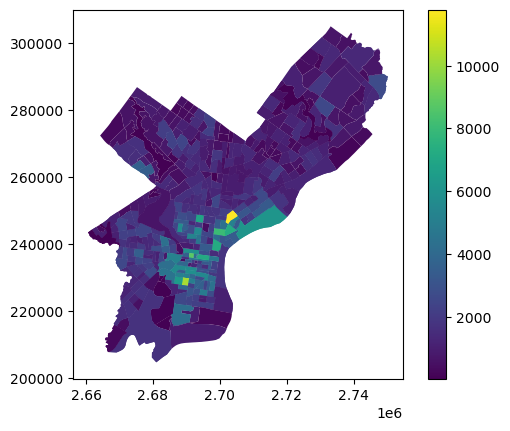

In [54]:
#plot new construction
lni_data.plot(column='cnt_construct', legend=True)

<AxesSubplot: >

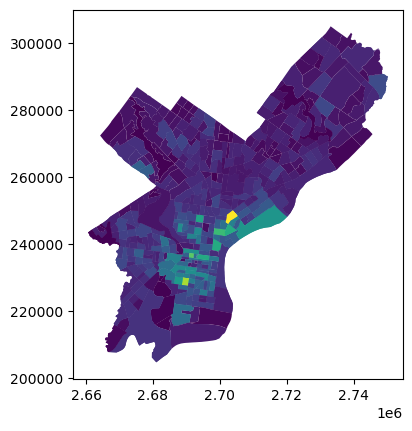

In [55]:
#plot contractor applicants
#unsurprisingly, the maps look the same
lni_data.plot(column='cnt_contract')

In [56]:
#save gdf to output folder
lni_data.to_file("output/lni_data.gpkg")

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\tup48123\AppData\Local\Temp\ipykernel_9600\205274334.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lni_data.to_file("output/lni_data.gpkg")
